## **Question 1. Robust Estimation**

1. Generate points that belong to a line segment with given parameters (angle and distance from the origin). Test your line generation by creating points for lines with angles between 0 and 90 degrees, and plot the results.
2. Add Gaussian noise with specified mean and standard deviation to the points of a specific line segment, and plot the noisy points. Ensure that the noise is visible.
3. Given the noisy points from the previous step, estimate the parameters of the original line and compute the error compared to the known parameters.
4. Plot a graph showing the error as a function of the noise level.
5. Introduce a percentage of outliers to the point set and re-estimate the line parameters. Plot the error as a function of the percentage of outliers.
6. Use the ```cv2.fitline``` function for robust line estimation, utilizing the ```cv2.DIST_HUBER``` distance. Plot the error as a function of the percentage of outliers.
7. Evaluate the algorithm and report results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## **Generate points that belong to a line segment and plot the results**

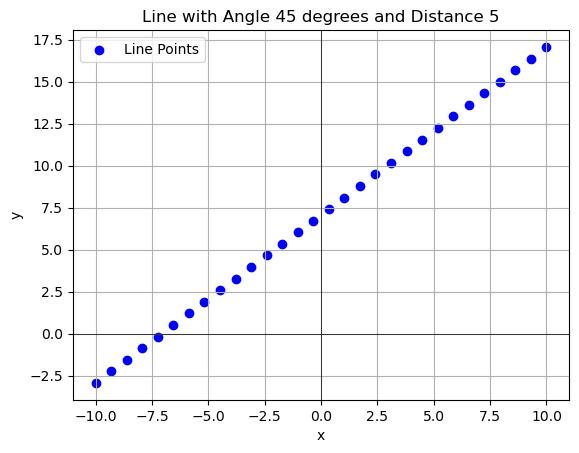

In [2]:
def generate_line_points(angle, distance_from_origin, num_points):
    # Convert the angle to radians
    angle_rad = np.deg2rad(angle)
    
    # Calculate the normal vector of the line [cos(angle), sin(angle)]
    normal_vector = np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    
    # Generate x values within the range of -10 to 10
    x_values = np.linspace(-10, 10, num_points)
    
    # Calculate y values using the implicit equation: n dot p = distance_from_origin
    # The equation becomes: n[0] * x + n[1] * y = distance_from_origin
    # Solve for y: y = (distance_from_origin - n[0] * x) / n[1]
    if np.isclose(normal_vector[1], 0):  # Special case for horizontal lines
        y_values = np.full_like(x_values, distance_from_origin / normal_vector[0])  # y remains constant
    else:
        y_values = (distance_from_origin - normal_vector[0] * x_values) / normal_vector[1]
    
    # Combine x and y into 2D points
    points = np.array([x_values, y_values]).T
    
    return points

# Set the parameters
angle = 45  # The angle of the line in degrees
distance_from_origin = 5  # The distance from the origin to the line
num_points = 30  # Number of points to generate

# Generate the points on the line
points = generate_line_points(angle, distance_from_origin, num_points)

# Plot the points on the line
plt.scatter(points[:, 0], points[:, 1], label='Line Points', color='blue')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title(f'Line with Angle {angle} degrees and Distance {distance_from_origin}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


## **Add Gaussian noise and plot the results**

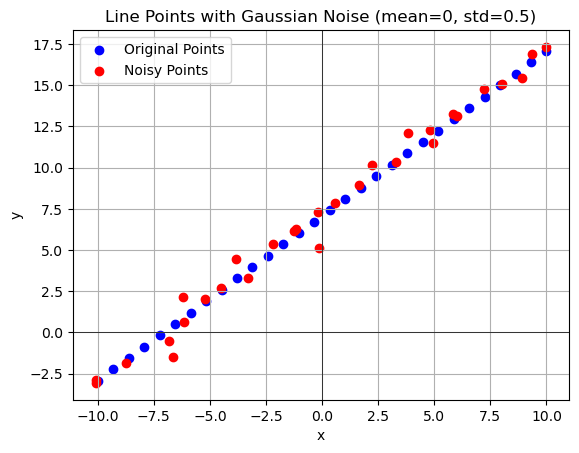

In [3]:
def add_gaussian_noise(points, mean, std):
    np.random.seed(512)  # Fix seed
    
    # Generate Gaussian noise with specified mean and standard deviation
    noise = np.random.normal(mean, std, points.shape)
    noisy_points = points + noise
    return noisy_points

# Set parameters for Gaussian noise
mean = 0
std = 0.5
noisy_points = add_gaussian_noise(points, mean, std)

# Plot original and noisy points
plt.scatter(points[:, 0], points[:, 1], label='Original Points', color='blue')
plt.scatter(noisy_points[:, 0], noisy_points[:, 1], label='Noisy Points', color='red')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title(f'Line Points with Gaussian Noise (mean={mean}, std={std})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## **Estimate the line from noisy points with ```cv2.DIST_L2``` and plot the results**

True angle: 45, Estimated angle: 45.75021743774414, Angle error: 0.7502174377441406
True distance: 5, Estimated distance: 4.997482776641846, Distance error: 0.002517223358154297


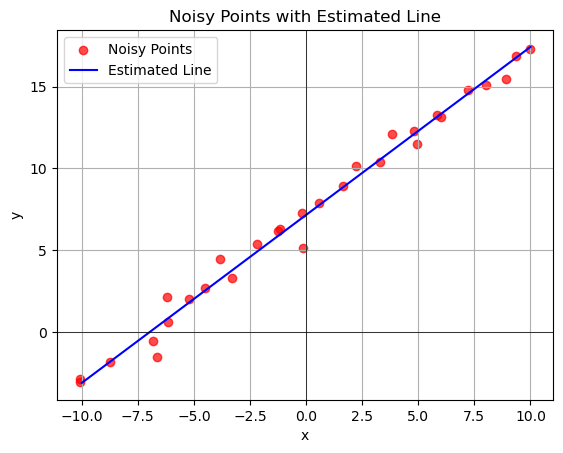

In [4]:
def estimate_line_params(noisy_points, distType):
    # Use cv2.fitLine to estimate line parameters from noisy points
    [vx, vy, x0, y0] = cv2.fitLine(noisy_points, distType, 0, 0.01, 0.01)
    
    # Calculate the estimated angle in radians and degrees
    estimated_angle_rad = np.arctan2(vy, vx)
    estimated_angle = np.rad2deg(estimated_angle_rad)
    
    # Calculate the estimated distance from the origin using the implicit line equation
    estimated_distance_from_origin = -np.sin(estimated_angle_rad) * x0 + np.cos(estimated_angle_rad) * y0
    
    return estimated_angle[0], estimated_distance_from_origin[0]

def compute_error(true_angle, true_distance, estimated_angle, estimated_distance_from_origin):
    # Compute L1 norm for angle and distance errors separately
    angle_error = np.abs(true_angle - estimated_angle)
    distance_error = np.abs(true_distance - estimated_distance_from_origin)

    return angle_error, distance_error

# Estimate line parameters from noisy points
estimated_angle, estimated_distance_from_origin = estimate_line_params(noisy_points, distType = cv2.DIST_L2)

# Compute the error compared to the known parameters
angle_error, distance_error = compute_error(angle, distance_from_origin, estimated_angle, estimated_distance_from_origin)

# Output the results
print(f"True angle: {angle}, Estimated angle: {estimated_angle}, Angle error: {angle_error}")
print(f"True distance: {distance_from_origin}, Estimated distance: {estimated_distance_from_origin}, Distance error: {distance_error}")

# Plot original noisy points and the estimated line
plt.scatter(noisy_points[:, 0], noisy_points[:, 1], label='Noisy Points', color='red', alpha=0.7)

# Plot the estimated line
# Using the estimated distance and angle for the line equation
vx, vy, x0, y0 = cv2.fitLine(noisy_points, cv2.DIST_L2, 0, 0.01, 0.01)
estimated_angle_rad = np.arctan2(vy, vx)
line_x = np.linspace(-10, 10, num_points)
line_y = (estimated_distance_from_origin + line_x * np.sin(estimated_angle_rad)) / np.cos(estimated_angle_rad)
plt.plot(line_x, line_y, label='Estimated Line', color='blue')

# Plot settings
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('Noisy Points with Estimated Line')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## **Plot the error as Gaussian noise level**

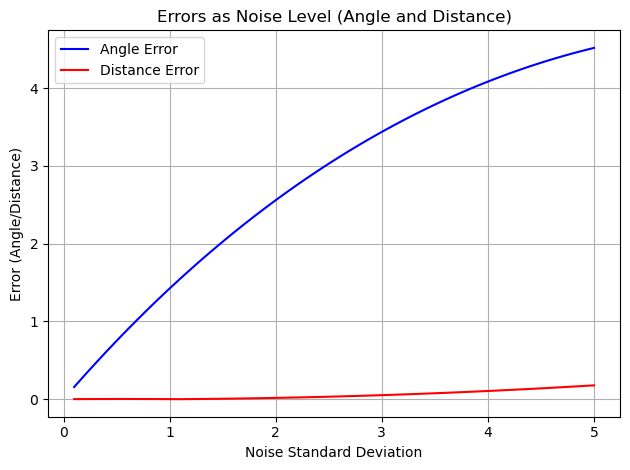

In [5]:
def plot_error_as_noise_level(angle, distance_from_origin, num_points, noise_levels):
    angle_errors = []
    distance_errors = []
    
    # Generate the original line points
    points = generate_line_points(angle, distance_from_origin, num_points)
    
    for std in noise_levels:
        # Add Gaussian noise to the points
        noisy_points = add_gaussian_noise(points, mean=0, std=std)
        
        # Estimate the line parameters from the noisy points
        estimated_angle, estimated_distance_from_origin = estimate_line_params(noisy_points, cv2.DIST_L2)
        
        # Compute the angle and distance errors
        angle_error, distance_error = compute_error(angle, distance_from_origin, estimated_angle, estimated_distance_from_origin)
        
        angle_errors.append(angle_error)
        distance_errors.append(distance_error)
        
    return noise_levels, angle_errors, distance_errors

# Define noise levels (standard deviation values)
noise_levels = np.linspace(0.1, 5.0, 50)

# Plot the error as a function of noise level
noise_levels, angle_errors, distance_errors = plot_error_as_noise_level(angle, distance_from_origin, num_points, noise_levels)

# Plot the errors as a function of noise level
plt.plot(noise_levels, angle_errors, label='Angle Error', color='blue')
plt.plot(noise_levels, distance_errors, label='Distance Error', color='red')
plt.title('Errors as Noise Level (Angle and Distance)')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Error (Angle/Distance)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Add outliers and estimate the line with ```cv2.DIST_L2``` and plot the error as the percentage of outliers**

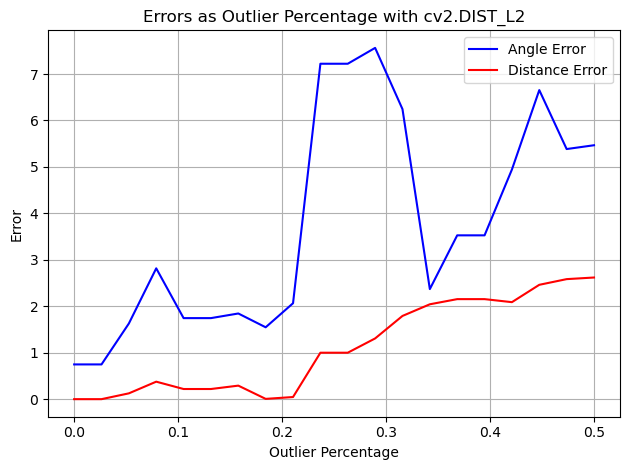

In [6]:
def add_outliers(points, percentage):
    np.random.seed(512)
    
    num_outliers = int(len(points) * percentage)
    # Add outliers with large values outside the original point range
    outliers = np.random.uniform(low=-20, high=20, size=(num_outliers, 2))
    
    # Combine original points with the outliers
    points_with_outliers = np.vstack((points, outliers))

    return points_with_outliers

def plot_error_as_outliers_percentages(points, angle, distance_from_origin, num_points, outlier_percentages, distType):
    angle_errors = []
    distance_errors = []
    
    for percentage in outlier_percentages:
        # Add outliers to the points
        noisy_points_with_outliers = add_outliers(points, percentage)
        
        # Estimate the line parameters from the noisy points with outliers
        estimated_angle, estimated_distance_from_origin = estimate_line_params(noisy_points_with_outliers, distType)
        
        # Compute the angle and distance errors
        angle_error, distance_error = compute_error(angle, distance_from_origin, estimated_angle, estimated_distance_from_origin)
        
        # Store the error values
        angle_errors.append(angle_error)
        distance_errors.append(distance_error)
        
    return outlier_percentages, angle_errors, distance_errors

# Define outlier percentages (from 0% to 50%)
outlier_percentages = np.linspace(0, 0.5, 20)

# Plot the error as a function of outlier percentage
outlier_percentages, angle_errors, distance_errors = plot_error_as_outliers_percentages(
    noisy_points,
    angle, 
    distance_from_origin, 
    num_points, 
    outlier_percentages, 
    distType = cv2.DIST_L2
    )

# Plot the angle and distance errors
plt.plot(outlier_percentages, angle_errors, label='Angle Error', color='blue')
plt.plot(outlier_percentages, distance_errors, label='Distance Error', color='red')
plt.title('Errors as Outlier Percentage with cv2.DIST_L2')
plt.xlabel('Outlier Percentage')
plt.ylabel('Error') 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Add outliers and estimate the line with cv2.DIST_HUBER and plot the error as the percentage of outliers**

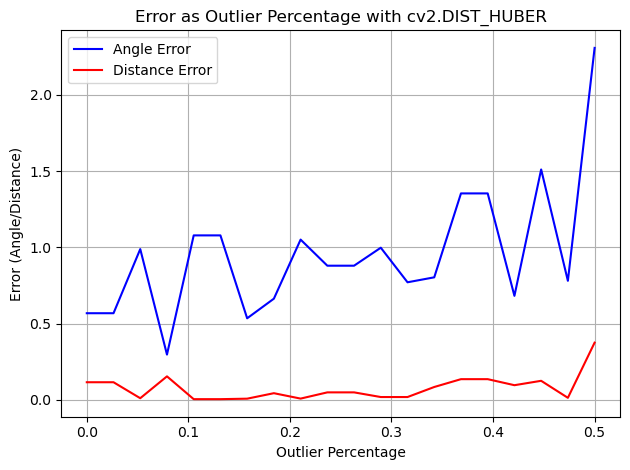

In [7]:
# Define outlier percentages (from 0% to 50%)
outlier_percentages = np.linspace(0, 0.5, 20)

# Plot the error as a function of outlier percentage using Huber Distance
outlier_percentages, angle_errors, distance_errors = plot_error_as_outliers_percentages(
    noisy_points,
    angle, 
    distance_from_origin, 
    num_points, 
    outlier_percentages, 
    distType = cv2.DIST_HUBER)

# Plot angle and distance errors as a function of outlier percentage
plt.plot(outlier_percentages, angle_errors, label='Angle Error', color='blue')
plt.plot(outlier_percentages, distance_errors, label='Distance Error', color='red')
plt.title('Error as Outlier Percentage with cv2.DIST_HUBER')
plt.xlabel('Outlier Percentage')
plt.ylabel('Error (Angle/Distance)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Evaluate the algorithm and report results**

**1. ```cv2_DIST_L2``` with Increasing Gaussian Noise**

The ```cv2.fitLine``` using ```cv2.DIST_L2``` works well with low noise levels. Errors in angle and distance remain small when noise is minimal. As noise increases, the errors rise significantly, making the algorithm less reliable under high noise conditions.

**2. ```cv2.DIST_L2``` with Increasing Outliers**

The L2 distance is highly sensitive to outliers. As the outlier percentage is increased, the errors become very large, making L2 unreliable in the presence of many outliers.

**3. ```cv2.DIST_HUBER``` with Increasing Outliers**

The Huber loss is more robust, with minimal error increases at low outlier percentages. It handles outliers better than L2. Even at higher outlier percentages, the errors remain controlled, allowing the algorithm to estimate the line more accurately.

**4. Comparison: ```cv2.DIST_L2``` vs ```cv2.DIST_HUBER```**

```cv2.DIST_L2```: Sensitive to outliers, resulting in large errors even with a small percentage of outliers.

```cv2.DIST_HUBER```: More robust to outliers, with better performance in noisy data.